华丽常常伴随着伟大，幸运更经常地来自于简单。---威·沃森.

在opensees(以下简称ops)中建立纤维截面是痛苦的，一是繁琐的命令流让人心猿意马，二是自己辛苦拉起的截面又没法看到。
这次分享的代码便是用一行命令可视化你的ops纤维截面。
大概人都是趋于懒散的，怕麻烦的，不想再到处搜集菜单式软件，而且授人以鱼不如授人以渔，不如把想法和代码直接分享。

借用一本python书的的名字《Python One-Liners》(https://wiki.python.org/moin/Powerful%20Python%20One-Liners)，一行流，就是把一个功能用一行代码去实现。
当然这里并不是只有一行命令，而是使用时只用一条命令，所有的代码都被封装起来。
一行流不是python的专有，但是python让你用pythonic的方式让事情更加简单。
下面我们就看到，如何利用你能利用的一切。

首先，我们把如下的代码复制到一个py文件里，使用时直接导入即可。

在函数里我已经尽可能作了详尽地注释，这里主要有三个东西需要说明一下：

1.利用openseespy库自带的eleResponse()命令，可以从当前的模型域里提取出纤维截面信息，由于只能提取出纤维点的坐标与面积，因此我们用带有面积的圆来可视化各纤维点。

2.python 不是一个对循环友好的语言，所以在画很多元素的图表时，尽量不用循环，这里用了matplotlib里的collections模块来一次生成所有带有面积的圆。

3.仅有的纤维信息不能判别材料类型，如果想突出钢筋，就传入钢筋直径数据。


In [1]:
import numpy as np
import matplotlib.collections
import matplotlib.pyplot as plt
import openseespy.opensees as ops


def ops_sec_vis(ele_tag, sec_num=1, rebar_d=None, color=None):
    """
    ele_tag: 要显示截面的所属单元号；
    sec_num: 显示单元上的哪个积分点截面，从i段到j段从1开始编号；
    rebar_d: 钢筋直径，若想突出显示钢筋，请传入一个标量或列表等，列表则表示有多种钢筋直径。
    color: 显示颜色，默认为渐变颜色，其值按与截面中心点的距离变化。
    """
    # 利用eleResponse()命令提取出纤维数据
    FiberData = ops.eleResponse(ele_tag, 'section', 'fiberData', sec_num)
    # FiberData从第1列至第5列分别为："yCoord", "zCoord", "area", "stress", "strain"
    FiberData = np.array(FiberData).reshape((-1, 5))   # 变形为5列数组
    ylocs, zlocs, areas = FiberData[:, 0], FiberData[:, 1], FiberData[:, 2]
    # 如下提取出边界与坐标中心
    ymin, ymax = np.min(ylocs), np.max(ylocs)
    zmin, zmax = np.min(zlocs), np.max(zlocs)
    ymean, zmean = np.mean(ylocs), np.mean(zlocs)
    
    # matplotlib 绘图
    plt.style.use('fivethirtyeight')
    # plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(8, 8))
    patches = [plt.Circle((yloc, zloc), np.sqrt(area / np.pi))
            for yloc, zloc, area in zip(ylocs, zlocs, areas)]
    coll = matplotlib.collections.PatchCollection(patches, alpha=0.75)
    if color is None:
        colors = (ylocs - ymean)**2 + (zlocs - zmean)**2
        coll.set_array(colors)
    else:
        coll.set_color(color)
    ax.add_collection(coll)
    
    # 如果包含钢筋
    if rebar_d is not None:
        rebar_d = np.atleast_1d(rebar_d)
        for d in rebar_d:
            rebar_area = np.pi * d ** 2 / 4
            idx = np.argwhere(np.abs(areas - rebar_area) < 1e-6)
            rebar_ys = ylocs[idx]
            rebar_zs = zlocs[idx]
            rebar_areas = areas[idx]
            patches_rebar = [plt.Circle((yloc, zloc), np.sqrt(area / np.pi))
                    for yloc, zloc, area in zip(rebar_ys, rebar_zs, rebar_areas)]
            coll_rebar = matplotlib.collections.PatchCollection(patches_rebar, color='black', alpha=1)
            ax.add_collection(coll_rebar)
    ax.set_aspect('equal')
    ax.set_xlim(ymin * 1.5, ymax * 1.5)
    ax.set_ylim(zmin * 1.5, zmax * 1.5)
    ax.set_xlabel('y', fontsize=20)
    ax.set_ylabel('z', fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show();

下面可以看到如何在建模过程中一行命令可视化截面。

首先，按照固有的流程随便建立一个opensees模型，这里用了两节点的单自由度模型，一节点被固定。
在此之前，建立了保护层、核心区的混凝土以及钢筋材料。

In [2]:

# 定义opensees模型中的材料，依次为保护层，核心区混凝土，以及钢筋
ops.wipe()
ops.model('basic', '-ndm', 3, '-ndf', 6)

# 混凝土材料，采用Cncrete01模型，如不确定下面不用改
vc = 0.2  # 混凝土泊松比
fc = -20.1E3  # 混凝土峰值强度
ec = -2E-3  # 混凝土峰值应变
fcu = -16.5E3  # 混凝土极限强度
ecu = -4E-3  # 混凝土极限应变
Ec = 2 * fc / ec  # 弹性模量
Gc = Ec / (2 * (1 + vc)) # 剪切模量

# ft40 = 2.39E+3       # 不考虑受拉强度
# et40 = 100.E-6
fccore = -26.8E3  # 约束混凝土峰值强度
eccore = -5.3E-3  # 约束混凝土峰值应变
fcucore = -23  # 约束混凝土极限强度
ecucore = -0.0157  # 约束混凝土极限应变

# 钢筋材料 （Steel01 Material. ）
Fys = 300E3  # 屈服应力
Es = 2.0E8  # 钢筋弹性模量
bs = 0.01  # 刚度硬化比
matTagC = 1
matTagCCore = 2
matTagSteel = 3
ops.uniaxialMaterial('Concrete01', matTagC, fc, ec, fcu, ecu)
ops.uniaxialMaterial('Concrete01', matTagCCore,
                    fccore, eccore, fcucore, ecucore)
ops.uniaxialMaterial('Steel01', matTagSteel, Fys, Es, bs)
# 建立节点
ops.node(1, 0.0, 0.0, 0.0)
ops.node(2, 0.0, 0.0, 0.0)
ops.fix(1, *([1]*6))

先建立一个矩形截面，尺寸和钢筋直径就直接取好了。

In [3]:

# 案例 1, 矩形截面
sec_Tag = 1
bar_d1 = 0.036
bar_d2 = 0.020
bar_area1 = np.pi * bar_d1 ** 2 / 4
bar_area2 = np.pi * bar_d2 ** 2 / 4
ops.section('Fiber', sec_Tag, '-GJ', 1)
ops.patch('quad', matTagCCore, 20, 20, -1, 1, -1, -1, 1, -1, 1, 1)  # Define the concrete patch
ops.layer('straight', matTagSteel, 15, bar_area1, -0.9, 0.9, -0.9, -0.9)
ops.layer('straight', matTagSteel, 30, bar_area2, 0.9, 0.9, 0.9, -0.9)
ops.layer('straight', matTagSteel, 15, bar_area1, -0.9, 0.9, 0.9, 0.9)
ops.layer('straight', matTagSteel, 30, bar_area2, -0.9, -0.9, 0.9, -0.9)

注意由于eleResponse()命令需要指定是哪个单元上的哪个积分点截面，因此在可视化之前需要先把单元定义了。
这里随便使用一个零长度单元。

In [4]:
# ops_sec_vis 必须在单元定义后才可使用
# 定义单元，单元号1
ops.element('zeroLengthSection', 1, 1, 2, sec_Tag)

如下便可以一行命令可视化截面了。

如果不传入color参数，默认使用一个颜色渐变图，随着距截面形心点的距离而变化。

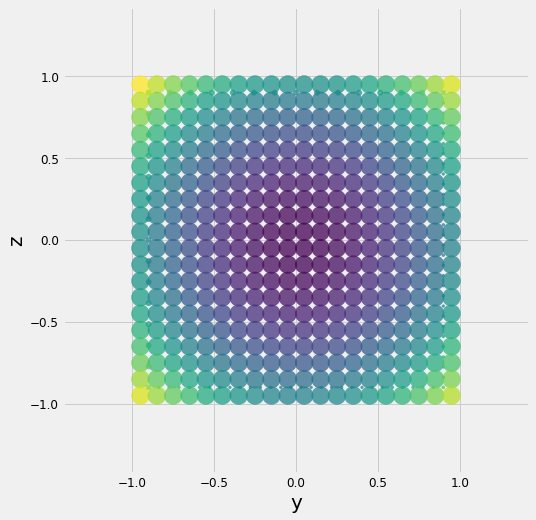

In [5]:
ops_sec_vis(ele_tag=1)  # 函数默认可视化该单元的第一个积分点截面

传入钢筋直径信息，既然前面用了两种钢筋直径，就把它们包成一个列表传进去就好了。

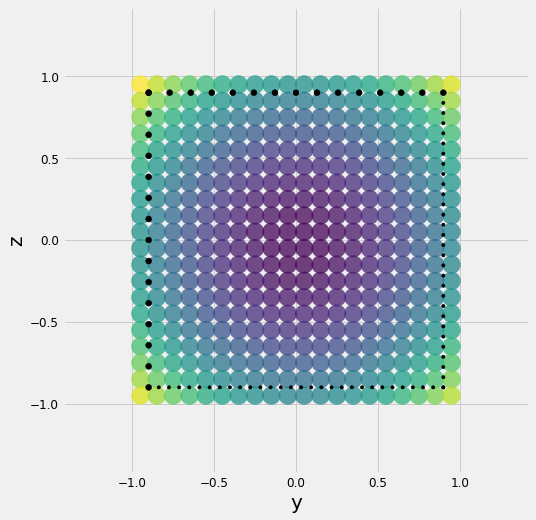

In [6]:
ops_sec_vis(ele_tag=1, rebar_d=[bar_d1, bar_d2])

传进去一个单一的颜色

推荐一个 xkcd颜色网站，(https://xkcd.com/color/rgb/)，可提取出相应颜色 十六进制代码。

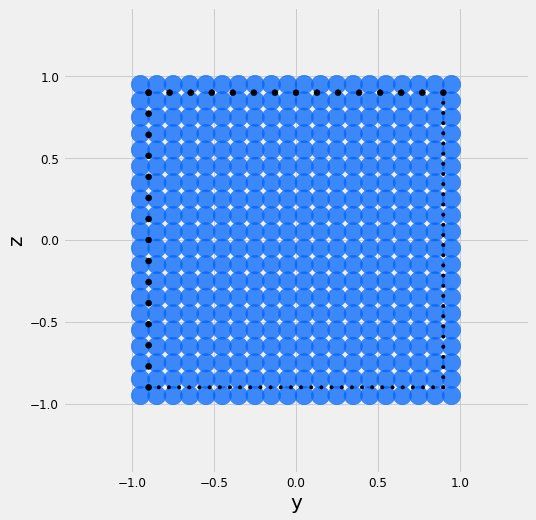

In [7]:
ops_sec_vis(ele_tag=1, rebar_d=[bar_d1, bar_d2], color='#0165fc')

再看一下圆形的截面

In [8]:
# 案例2 圆形截面
# 定义墩纤维截面
pier_d = 1.3  # 墩直径
cover = 0.05  # 保护层厚度
bar_d = 0.022  # 钢筋直径
bar_ratio = 0.01  # 配筋率
mesh_size = 0.1  # 混凝土截面纤维控制尺寸
# 定义墩截面类型以及截面
# 定义墩纤维截面
pier_area = np.pi * (pier_d / 2) ** 2
bar_area = np.pi * bar_d * bar_d / 4
bar_num = int(pier_area * bar_ratio / bar_area)   # 利用配筋率反求钢筋数量
sec_Tag = 2
ops.section('Fiber', sec_Tag, '-GJ', 0.5 * np.pi * (pier_d / 2) ** 4)
ops.patch('circ', matTagC, int(np.pi * pier_d / mesh_size), 1, *
[0, 0], *[pier_d / 2 - cover, pier_d / 2], *[0, 360])
ops.patch('circ', matTagCCore, int(np.pi * pier_d / mesh_size), int(0.5 * pier_d / mesh_size),
          *[0, 0], *[0, pier_d / 2 - cover], *[0, 360])
ops.layer('circ', matTagSteel, bar_num, bar_area, *[0, 0],
          pier_d / 2 - cover - bar_d / 2, *[0.0, 360.0 - 360 / 35])
# 建立单元
ops.element('zeroLengthSection', 2, 1, 2, sec_Tag)  

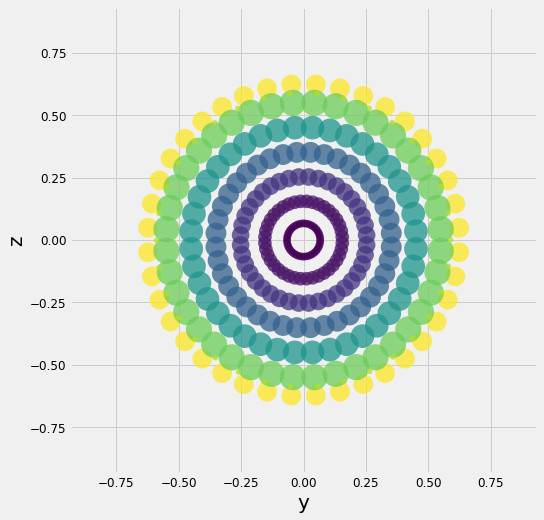

In [9]:
ops_sec_vis(ele_tag=2)

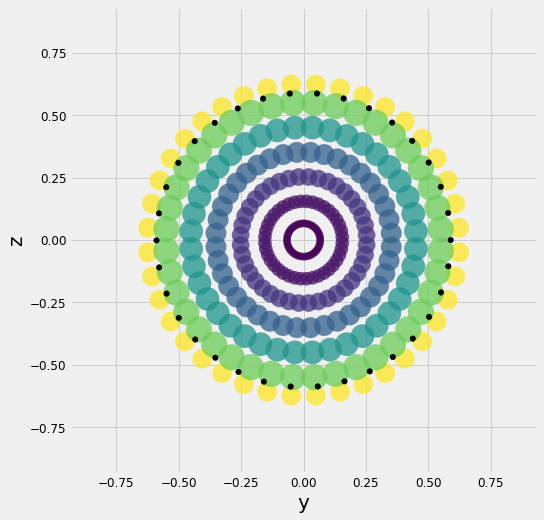

In [10]:
ops_sec_vis(ele_tag=2, sec_num=1, rebar_d=bar_d)